### Instructions

No prior setup required. On jupyter, use Kernel > Restart & Run All to see results.

### Import libraries

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification

### Generate Dataset

In [2]:
X, y = make_classification(n_samples=500, n_features=3, n_informative=3,
                           n_redundant=0, n_clusters_per_class=1,
                           flip_y=0.1,  # adds a small amount of noise
                           class_sep=1.0,  # classes are separable but not too easily
                           random_state=40)

### Relabel the Y targets to +1/-1

In [3]:
y = np.where(y == 0, -1, 1)

### Split the dataset into training and testing datasets

In [4]:
# using the sklearn.model_selection library
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### SVM

In [33]:
def svm_loss(X, y, w, b, C):
    # loss equations from the assignment PDF

    # hinge loss
    hinge_loss = np.maximum(0, 1 - y * (np.dot(X, w) + b))
    
    # l2 regularization term
    regularization_term = 0.5 * np.dot(w, w)
    
    # total loss = mean of hinge loss + regularization Term
    loss = np.mean(hinge_loss) + C * regularization_term
    
    # identify incorrectly classified samples
    # y⋅(w⋅X+b)<1 = soft-margin SVM constraint
    # np.dot(X, w) + b = distance of each sample from the decision boundary 
    incorrect = y * (np.dot(X, w) + b) < 1
    
    # gradients of loss with respect to weights and bias
    # sum up the misclassified target labels and calculate mean
    dw = -np.dot(X[incorrect].T, y[incorrect]) / len(X) + C * w
    db = 0 if np.max(1 - y * (np.dot(X, w) + b)) <= 0 else -C * np.sum(y[incorrect]) / len(X)
    
    return loss, dw, db

def soft_margin_svm(X, y, C=1, learning_rate=0.01, epochs=100, batch_size=64):
    # initialize weights and bias
    num_features = X.shape[1]
    w = np.zeros(num_features)
    b = 0

    # to store loss values over epochs
    losses = []

    for epoch in range(epochs):
        # shuffle the data
        shuffled_indices = np.random.permutation(len(X))
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]

        # mini-batch gradient descent
        for batch_start in range(0, len(X), batch_size):
            batch_end = batch_start + batch_size
            X_batch = X_shuffled[batch_start:batch_end]
            y_batch = y_shuffled[batch_start:batch_end]

            # calculate loss and gradients using mini-batch
            loss, dw, db = svm_loss(X_batch, y_batch, w, b, C)

            # update weights and bias
            w -= learning_rate * dw
            b -= learning_rate * db

        losses.append(loss)

        # visualize the loss function over time during training
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

    return w, b, losses

# add a bias term to the features
X_with_bias = np.c_[X, np.ones(X.shape[0])]

# train the soft-margin SVM
optimal_weights, optimal_bias, losses = soft_margin_svm(X_with_bias, y, C=1, learning_rate=0.01, epochs=100, batch_size=64)

X_test_with_bias = np.c_[x_test, np.ones(x_test.shape[0])]

Epoch 0, Loss: 0.8904730407369376
Epoch 10, Loss: 0.5914312258273888
Epoch 20, Loss: 0.5456146822694057
Epoch 30, Loss: 0.6683371350541951
Epoch 40, Loss: 0.609411665985033
Epoch 50, Loss: 0.5985089227127729
Epoch 60, Loss: 0.6679900719026121
Epoch 70, Loss: 0.5367677910380706
Epoch 80, Loss: 0.6189834428219634
Epoch 90, Loss: 0.5032434543482815


### Perform some predictions on the test data

In [34]:
# perform predictions using the trained weights and bias
predictions = np.sign(np.dot(X_test_with_bias, optimal_weights) + optimal_bias)

# convert predictions to +1/-1 labels
predictions = np.where(predictions > 0, 1, -1)

### Calculate the accuracy score

In [35]:
accuracy = accuracy_score(y_test, predictions)

print("\nAccuracy:", accuracy)


Accuracy: 0.84


### Visualize the loss function over time during training

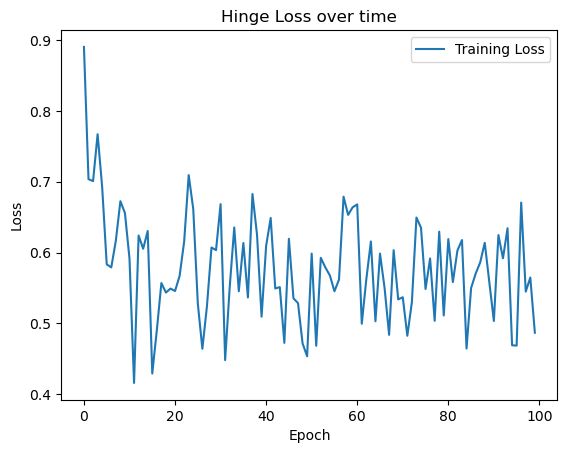

In [36]:
# plotting the loss over time
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Hinge Loss over time')
plt.legend()
plt.show()

### Visualize the training data and decision boundary in 3D

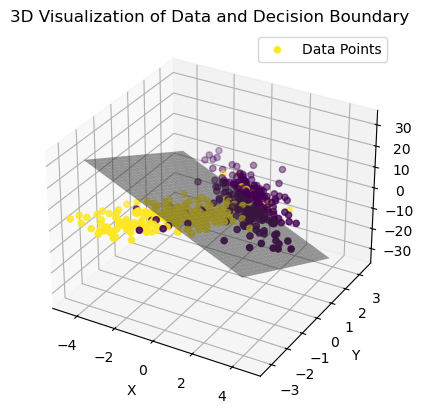

In [37]:
def plot_3d_decision_boundary(X, y, w, b):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # plot data points
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', marker='o', label='Data Points')

    # create a meshgrid for decision boundary
    x_min, x_max = -4, 4
    y_min, y_max = -3, 3
    z_min, z_max = -10, 10
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # compute corresponding z values for decision boundary
    zz = (-w[0] * xx - w[1] * yy - b) / w[2]

    # plot decision boundary
    ax.plot_surface(xx, yy, zz, alpha=0.5, color='grey')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.title('3D Visualization of Data and Decision Boundary')
    plt.legend()
    plt.show()
    
# plot 3D decision boundary
plot_3d_decision_boundary(X, y, optimal_weights[:-1], optimal_bias)